In this notebook I will implementing the new decoder module discussed with _Christoph_. From the encodings given by the __ESM__ encoder we begin by attaching two layers of standard _Multi-Head self-attention_ which we then train by minimising the _pseudo-likelihhod_(find package).
Remember that from here we assume to be working with tensors, not graphs anymore. Our hope is that all of the relevant information coming from the graph structure has already been encoded in the embeddings of the encoder.

In [1]:
import torch 
from torch.nn import TransformerEncoderLayer, Linear
from torch import Tensor
from torch.nn.functional import one_hot
import pickle
import os
from torch.utils.data import Dataset, DataLoader, RandomSampler, Subset
import matplotlib.pyplot as plt
import numpy as np
#from torch_geometric.loader import DataLoader

In [107]:
## I think I have to be carefull at the dimensions of the objects
class Potts_Decoder(torch.nn.Module):
    def __init__(self, n_cat:int, n_layers:int, atten_dim:int, embed_dim:int, n_heads:int, dropout=0.0):
        ## We use the init of the superclass Module
        super().__init__()
        #self.system_size = system_size       ##length of the amino-acid
        self.n_cat = n_cat                   ## for proteins this is 21, fix??
        self.n_layers = n_layers
        self.atten_dim = atten_dim           ## this is the input dimension for the attention layer
        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.dropout = dropout
        
        self.attentions = torch.nn.ModuleList()
        self.attentions_activated = []
        for _ in range(n_layers):
            attention_layer = TransformerEncoderLayer(self.atten_dim, self.n_heads,
                                                      dropout=self.dropout, batch_first=True)
            self.attentions.append(attention_layer)
            self.attentions_activated.append(attention_layer)
            self.attentions_activated.append(torch.nn.ReLU())
        
        self.attentions_sequential = torch.nn.Sequential(*self.attentions_activated)
        
        ## Maybe add a Linear Layer (usually always done)
        self.Linear = Linear(self.atten_dim, self.n_cat*self.embed_dim) ##21 is the number of amino-acids + skip character
        
        
        
    def forward(self, x, coupling_mask, padding_mask=None):
        ## Padding mask is of silve [B, L_max]
        ## I have to provide two masks, one for the coupling matrix, one for the padding
        ## For the moment suppose a single protein, the batch_size is in the first dimension
        ## Here I suppose batch_first
        #print(x.shape)
        ## I expect to have something like [1, L, 512]
        L = x.shape[1]
        ## This now, if we have a batch, it is going to be the maximum batch_size

        # (L x q x embed_dim)
        x = self.attentions_sequential(x, src_key_padding_mask=padding_mask).squeeze()
        ## For the moment I suppose to have a single obs
        ## We have to output a matrix, not a vector, we hence do the opposite of CNNs
        x = self.Linear(x, src_key_padding_mask=padding_mask).reshape(L, self.n_cat, self.embed_dim) ##Not sure we can do this
        
        #coupling = x.reshape(L, 1, 21, self.embed_dim) @ torch.transpose(x, 1, 2).reshape(1, L, self.embed_dim, 21)
        #coupling = torch.transpose(coupling, 1, 2).reshape(L*21, L*21) ##check whether this is correct, looks yes
        coupling = torch.flatten(x, end_dim=1) @ torch.flatten(torch.transpose(torch.transpose(x, 2, 0), 1, 2), 
                                                               start_dim=1)
        #print(coupling.shape)
        fields = torch.diag(coupling).reshape(L, self.n_cat)
        coupling = coupling * mask     ## element-wise product ##still have to be carefull at padding mask...need to be sure is fine
        #coupling = 0.5*(coupling + torch.transpose(coupling,0,1))
        
        ##This recovers the overall coupling matrix
        coupling = coupling + torch.transpose(coupling, 0, 1)
        #for i in range(L):
        #    coupling[i*self.n_cat : (i+1)*self.n_cat, i*self.n_cat : (i+1)*self.n_cat] = 0.0    
        
        return fields, coupling, padding_mask  #### we have to return the mask
    
    
    
def Pseudo_Likelihood(model, data:Tensor, fields:Tensor, coupling:Tensor, padding_mask:Tensor=None, one_hot_input:bool = False) -> Tensor:
    seq = data[0]
    if not one_hot_input:
        data = one_hot(data, num_classes = model.n_cat).float().view(data.shape[0], -1)
    if padding_mask is None:
        return torch.mean(torch.logsumexp(energy_diffs(model, data, fields, coupling, one_hot_input=True), dim=-1), axis=-1) 
    else:
        energy_diffs, padding_mask = energy_diffs(model, data, fields, coupling, padding_mask=padding_mask, one_hot_input=True)
        return np.sum(torch.logsumexp(energy_diffs, dim=-1), axis=-1)/np.sum(padding_mask, axis=-1)
               

def Local_Fields(model, data: Tensor, fields:Tensor, coupling:Tensor, one_hot_input: bool = False) -> Tensor:
    ndata: int = data.shape[0]
    system_size = coupling.shape[0]//model.n_cat
    if not one_hot_input:
        data = one_hot(data, num_classes = model.n_cat).float().view(data.shape[0], -1)
    return data.float() @ coupling + fields.T.reshape(1, -1).expand(ndata, system_size*model.n_cat) 

def energy_diffs(model, data: Tensor, fields:Tensor, coupling:Tensor, padding_mask:Tensor = None, one_hot_input: bool = False) -> Tensor:

    ndata: int = data.shape[0]
    system_size = coupling.shape[0]//model.n_cat
    if not one_hot_input:
        data = one_hot(data, num_classes = model.n_cat).float().view(data.shape[0], -1)
    ## We extract the local fields vector
    local_fields: Tensor = Local_Fields(model, data, fields, coupling, one_hot_input=True)
    
    ## torch.mul is element-wise product
    local_fields_with_deltas: Tensor = torch.mul(local_fields, data)
    local_fields_with_deltas = local_fields_with_deltas.reshape(ndata, system_size, model.n_cat)
    local_fields_true: Tensor = torch.sum(local_fields_with_deltas, axis=-1)
    local_fields_true = local_fields_true.unsqueeze(-1).expand(ndata, system_size, model.n_cat)
    energy_diffs: Tensor = local_fields_true - local_fields.reshape(ndata, system_size, model.n_cat) 
    if padding_mask is None:
        return -1*energy_diffs
    else:
        energy_diffs = energy_diffs*padding_mask        ##Element-wise product, does it broadcast automatically?
        return (-1*energy_diffs, padding_mask)

def energy_diffs_position(model, position: int, data: Tensor, fields:Tensor, coupling:Tensor, one_hot_input: bool = False) -> Tensor:

    if not one_hot_input:
        data = one_hot(data, num_classes = model.n_cat).float().view(data.shape[0], -1)

    energy_diffs: Tensor = energy_diffs(model, data, fields, coupling, one_hot_input=True)
    ##position is the amino acid position 
    return energy_diffs[:, position]

In [108]:
def load_obj(file):
    with open(file, 'rb') as f:
        return pickle.load(f)

In [109]:
letter_to_num = {'C': 4, 'D': 3, 'S': 15, 'Q': 5, 'K': 11, 'I': 9,
                       'P': 14, 'T': 16, 'F': 13, 'A': 0, 'G': 7, 'H': 8,
                       'E': 6, 'L': 10, 'R': 1, 'W': 17, 'V': 19, 
                       'N': 2, 'Y': 18, 'M': 12, 'X':20}
# 'X' I think is -
## got this conversion from GVP github.
##This seems very very odd.

In [110]:
class Encoded_Proteins(Dataset):
    def __init__(self, path_dir, transform=None, target_transform=None):
        self.path_dir = path_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(os.listdir(path_dir))

    def __getitem__(self, idx):
        #protein_path = self.path_dir + '/CATH_430_' + str(idx) 
        protein_file = os.path.join(self.path_dir, os.listdir(self.path_dir)[idx])
        d = load_obj(protein_file)
        encoded_protein = d['Encoded_Protein']
        #native_seq = d['Native_Seq']
        num_seq = d['Num_Seq']
        if self.transform:
            encoded_protein = self.transform(encoded_protein)
        if self.target_transform:
            native_seq = self.target_transform(native_seq)
        return encoded_protein, num_seq

In [111]:
def default_collate(batch):
    """
    Fill in
    """
    #item = batch[0]
    #print(item)
    
    data_x = [item[0] for item in batch]
    data_y = [item[1] for item in batch]
    # each element is of size (1, h*, w*). where (h*, w*) changes from mask to another.
    ## data_y is already numerical
    return data_x, data_y


Let us study the distribution of lengths for proteins inside the folder to assess if padding is sensible.

In [112]:
#path_dir = "C:/Users/Lucas/Desktop/Encoded_Proteins"
path_dir = "./Encoded_Proteins_Toy"
lengths = np.zeros(len(os.listdir(path_dir)[1:5]))
idx = 0
for file in os.listdir(path_dir)[1:5]:
    print(f"We are at iteration: {idx}", end="\r")
    fpath = os.path.join(path_dir, file)
    d = load_obj(fpath)
    lengths[idx] = len(d['Native_Seq'])
    idx+=1
    

(array([2., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 57. ,  78.2,  99.4, 120.6, 141.8, 163. , 184.2, 205.4, 226.6,
        247.8, 269. ]),
 <BarContainer object of 10 artists>)

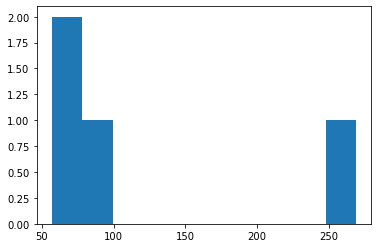

In [113]:
plt.hist(lengths)

In [114]:
np.mean(lengths)

121.5

In [115]:
np.max(lengths)

269.0

In [116]:
np.sum(lengths>512)/31878 * 100

0.0

In [117]:
np.sum(lengths > 1024)

0

We have $4$ sequences over 1024, and $0.36\%$ over 512. We can do what Christoph suggested of subsampling.

In [120]:
n_cat:int = 21
n_layers:int=2
atten_dim:int=512
embed_dim:int=5
n_heads:int=16
batch_size:int=4
#dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=default_collate, shuffle=True)

#decoder = Potts_Decoder(system_size, n_cat, n_layers, atten_dim, embed_dim, n_heads).to(device)
lr = 0.001

logging = []
#device='cuda'
device='cpu'
#optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
decoder = Potts_Decoder(n_cat, n_layers, atten_dim, embed_dim, n_heads).to(device)


data_x = d['Encoded_Protein'].reshape((1, 269, 512))
data_y = d['Num_Seq']

system_size=data_x.shape[1]
mask: Tensor = torch.triu(torch.ones(system_size*decoder.n_cat, system_size*decoder.n_cat, dtype=bool), 1)  
for i in range(system_size):
    mask[i*n_cat : (i+1)*n_cat, i*n_cat : (i+1)*n_cat] = 0              
mask: Tensor = torch.nn.Parameter(mask, requires_grad=False).to(device)
##We have to change how we save the output... necessarely
fields, couplings = decoder(data_x, mask)
#fields, couplings = decoder(data_x)
#seq_vals=torch.zeros(len(data_y), dtype=int)
#for char,idx in zip(data_y, range(len(data_y))):
#    seq_vals[idx] = letter_to_num[char]
hot = one_hot(data_y, num_classes=decoder.n_cat)
hot = torch.flatten(hot).unsqueeze(dim=0).to(device)
#print(system_size)

TypeError: forward() got an unexpected keyword argument 'src_key_padding_mask'

In [130]:
layer = torch.nn.Sequential(*[TransformerEncoderLayer(atten_dim, n_heads, dropout=0.1, batch_first=True)]*2)
layer.forward(data_x, src_key_padding_mask=None)

## How to pass src_key_padding_mask when we have a nn.Sequential???

TypeError: forward() got an unexpected keyword argument 'src_key_padding_mask'

Sequential(
  (0): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (1): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementw

In [23]:
data_x.shape

torch.Size([1, 269, 512])

In [29]:
res = energy_diffs(decoder, hot, fields, couplings, one_hot_input=True)

In [34]:
res[0].diag()

tensor([ -0.0000,  23.3927,  15.1612, -64.7930, -39.7287, -72.9019,  11.9301,
         -9.1051, -12.5873,  27.2541,   4.0941, -62.8168, -20.7636,  -2.0990,
        -37.6164,   7.0877,  62.4991, -65.0751, -23.8281, -26.2913,  29.7830],
       grad_fn=<DiagBackward0>)

In [36]:
prev = one_hot(data_y, num_classes=decoder.n_cat)

In [68]:
#torch.argmax(prev[7])

In [73]:
############ PATH FOR PERSONAL COMPUTER ################
path_dir = "./Encoded_Proteins_Toy"

########### PATH FOR OFFICE COMPUTER #################
#path_dir = "C:/Users/lucas/Desktop/Encoded_Proteins_Toy"

########## PATH FOR GOOGLE COLAB ####################
#path_dir = "./sample_data/Encoded_Proteins_Toy"


#dataloader = DataLoader(dataset, batch_size=4, collate_fn=default_collate, shuffle=True)

In [76]:
dataset = Encoded_Proteins(path_dir)
print(len(dataset))
dataset_train = Subset(dataset, np.arange(100))
dataset_test = Subset(dataset, np.arange(start=100, stop=148))
dataloader_train = DataLoader(dataset_train, collate_fn=default_collate, batch_size=4, shuffle=True)
dataloader_test = DataLoader(dataset_test, collate_fn=default_collate, batch_size=4, shuffle=True)

1321


In [77]:
len(dataloader_train) ### I have 250 batches of size 4 each

25

In [ ]:
#dataset_train[1][1].shape

In [81]:
#system_size:int = data.shape[0]
n_cat:int = 21
n_layers:int=2
atten_dim:int=512
embed_dim:int=5
n_heads:int=16
batch_size:int=4
#dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=default_collate, shuffle=True)

#decoder = Potts_Decoder(system_size, n_cat, n_layers, atten_dim, embed_dim, n_heads).to(device)
lr = 0.001

logging = []
#device='cuda'
device='cpu'
#optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
decoder = Potts_Decoder(n_cat, n_layers, atten_dim, embed_dim, n_heads).to(device)
optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
loss_f = Pseudo_Likelihood

losses_train = []
losses_test = []

num_epochs = 100

## Set the decoder to training mode
for epoch in range(1, num_epochs + 1):
    decoder.train()
    total_loss = 0
    iterator=0
    for data_xs, data_ys in dataloader_train:
        print(f"iterator:{iterator}", end="\r")
        iterator+=1
        for data_x, data_y in zip(data_xs, data_ys):
            data_x = data_x.unsqueeze(0).to(device)
            system_size=data_x.shape[1]
            mask: Tensor = torch.triu(torch.ones(system_size*decoder.n_cat, system_size*decoder.n_cat, dtype=bool), 1)  
            for i in range(system_size):
                mask[i*n_cat : (i+1)*n_cat, i*n_cat : (i+1)*n_cat] = 0              
            mask: Tensor = torch.nn.Parameter(mask, requires_grad=False).to(device)
            ##We have to change how we save the output... necessarely
            fields, couplings = decoder(data_x, mask)
            #fields, couplings = decoder(data_x)
            #seq_vals=torch.zeros(len(data_y), dtype=int)
            #for char,idx in zip(data_y, range(len(data_y))):
            #    seq_vals[idx] = letter_to_num[char]
            hot = one_hot(data_y, num_classes=decoder.n_cat)
            hot = torch.flatten(hot).unsqueeze(dim=0).to(device)
            #print(system_size)

            loss = loss_f(decoder, hot, fields, couplings, one_hot_input=True)/batch_size
            total_loss += float(loss)
            loss.backward()
        optimizer.step()
    losses_train.append(total_loss)
    print(f"We are at epoch:{epoch}, loss is:{total_loss}", end="\r")
    optimizer.zero_grad()
    
    
    #################################### TESTING #########################################
    total_loss_test = 0
    #losses_test = []
    decoder.eval()
    for data_xs, data_ys in dataloader_test:
        for data_x, data_y in zip(data_xs, data_ys):
            data_x = data_x.unsqueeze(0).to(device)
            system_size=data_x.shape[1]
            mask: Tensor = torch.triu(torch.ones(system_size*decoder.n_cat, system_size*decoder.n_cat, dtype=bool), 1)  
            for i in range(system_size):
                mask[i*n_cat : (i+1)*n_cat, i*n_cat : (i+1)*n_cat] = 0              
            mask: Tensor = torch.nn.Parameter(mask, requires_grad=False).to(device)
            ##We have to change how we save the output... necessarely
            fields, couplings = decoder(data_x, mask)
            #fields, couplings = decoder(data_x)
            #seq_vals=torch.zeros(len(data_y), dtype=int)
            #for char,idx in zip(data_y, range(len(data_y))):
            #    seq_vals[idx] = letter_to_num[char]
            hot = one_hot(data_y, num_classes=decoder.n_cat)
            hot = torch.flatten(hot).unsqueeze(dim=0).to(device)
            #print(system_size)

            loss = loss_f(decoder, hot, fields, couplings, one_hot_input=True)/batch_size
            total_loss_test += float(loss)
    
    losses_test.append(total_loss_test)
    #train_acc = test(train_loader)
    #test_acc = test(test_loader)
    #logging.append({"Epoch": epoch, "value": total_loss, "kind": "Loss"})
    #logging.append({"Epoch": epoch, "value": train_acc, "kind": "Train_acc"})
    #logging.append({"Epoch": epoch, "value": test_acc, "kind": "Test"})


In [ ]:
import matplotlib.pyplot as plt

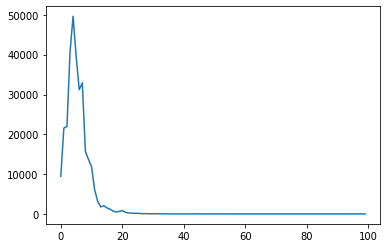

In [ ]:
plt.plot(losses_train)

In [ ]:
losses_test

[34.974768579006195]

## LET US TRY TO BUILD A NEW LOADER
- This loader has to be able to deal with batches which first patches to a common dimension and then returns them patched.
- We have to make sure patched parts are ignored from the algorithm.

In [42]:
?tensor.detach()

Object `tensor.detach()` not found.


In [57]:
path_dir = "./Encoded_Proteins_Toy"
fname = os.listdir(path_dir)[0:2]
fpath1 = os.path.join(path_dir, fname[0])
d1 = load_obj(fpath1)

fpath2 = os.path.join(path_dir, fname[1])
d2 = load_obj(fpath2)
## This just auxualiry
d_list = [d1, d2]

In [77]:
## This function is supposed to batch to a common dimension. You also have to batch the output!!!!
def parse_batch(batch):
    ## Here batch has to be an iterable of proteins structures
    B = len(batch)
    ## Maybe not maximum?
    L_max = max([len(b['Num_Seq']) for b in batch])
    #X = np.zeros([B, L_max, 4, 3], dtype=np.float32)
    #S = np.zeros([B, L_max], dtype=np.int32)
    X = torch.zeros([B, L_max, 512], dtype=torch.float32)
    S = torch.zeros([B, L_max], dtype=torch.int8)
    
    for i, b in enumerate(batch):
        l = len(b['Native_Seq'])
        x = b['Encoded_Protein'].detach().numpy()

        X[i] = torch.tensor(np.pad(x, [[0, L_max-l], [0,0]], 'constant', constant_values=(np.nan, )))
        S[i, :l] = b['Num_Seq'] ## Do we leave to 0 all the other values?
            
    isnan = torch.isnan(X)
    mask = torch.isfinite(torch.sum(X, axis=2)) #.astype(torch.bool)
    X[isnan] = 0.
    X = torch.nan_to_num(X)
    
    return X, S, mask

## This function is supposed to batch to a common dimension. You also have to batch the output!!!!
class DynamicLoader(): 
    def __init__(self, dataset, batch_size=3000, shuffle=True): 
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def batch(self):
        dataset = self.dataset
        lengths = [len(b['seq']) for b in dataset]

        clusters, batch = [], []
        for ix in np.argsort(lengths):
            size = lengths[ix]
            if size * (len(batch) + 1) <= self.batch_size:
                batch.append(ix)
            else:
                if len(batch) > 0: clusters.append(batch)
                batch = [ix]
        if len(batch) > 0:
            clusters.append(batch)
        self.clusters = clusters
        print(len(clusters), 'batches', len(dataset), 'structures')

    def __iter__(self):
        self.batch()
        if self.shuffle: np.random.shuffle(self.clusters)
        N = len(self.clusters)
        for b_idx in self.clusters[:N]:
            batch = [self.dataset[i] for i in b_idx]
            yield parse_batch(batch)

In [78]:
import time

In [81]:
start = time.time()
X, S, mask = parse_batch(d_list)
print(time.time()-start)

0.005121946334838867


In [64]:
#X

In [62]:
len(d2['Native_Seq'])

83

Code for Homologous sequences by Christoph

#/bin/bash


cathfile=$1
maxcon=100

for id in $(awk -F'|' '/>/{split($3, a, "/"); pdb=substr(a[1], 1, 4); chain=substr(a[1], 5, 1); printf "%s_%s\n",pdb,chain}' cath-dataset-nonredundant-S20.fa | head -n 1000); do
	aws s3 cp --no-sign-request s3://openfold/pdb/${id}/a3m/uniref90_hits.a3m ./${id}.a3m &
	n=$(jobs -p | wc -l)
    	if [[ $n -ge $maxcon ]]; then
        	echo "waiting for jobs to finish ($n running)"
        	sleep 1
	fi
done

In [106]:
?TransformerEncoderLayer.forward

Signature:
TransformerEncoderLayer.forward(
    self,
    src: torch.Tensor,
    src_mask: Union[torch.Tensor, NoneType] = None,
    src_key_padding_mask: Union[torch.Tensor, NoneType] = None,
) -> torch.Tensor
Docstring:
Pass the input through the encoder layer.

Args:
    src: the sequence to the encoder layer (required).
    src_mask: the mask for the src sequence (optional).
    src_key_padding_mask: the mask for the src keys per batch (optional).

Shape:
    see the docs in Transformer class.
File:      ~/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/transformer.py
Type:      function
